# COVID-19 Yield Curve Dynamics: A Treasury Term Structure Analysis (1975-2024)

This project studies how the U.S. Treasury yield curve has evolved over time, with a particular focus on the economic shock brought on by the COVID-19 pandemic. Using publicly available data from the Federal Reserve Bank of St. Louis (FRED), the analysis explores long-term yield movements across maturities, the behaviour of yields during recession periods, and the interaction between short, medium, and long-term rates.

The project examines how the COVID-19 crisis led to rapid changes in the level, slope, and curvature of the yield curve, and how these developments compare to other historical episodes such as the Global Financial Crisis. By analysing yield curve shapes on specific dates, plotting steepening and flattening dynamics, and investigating the 10Y-2Y spread as an economic indicator, the study provides a clear picture of how large macroeconomic shocks propagate across the term structure.

The goal is to develop a structured, data-driven understanding of:
- How Treasury yields responded to the pandemic
- How the yield curve shifted, steepened, or inverted at various stages
- What the level, slope, and curvature reveal about market expectations
- How COVID-era behaviour compares with previous cycles
- Why the yield curve remains a key signal for economic conditions

# 1. Government Data

### 1.1 Importing Libraries


In [2]:
# 1.1 Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

# Set a basic seaborn style for plots
sns.set()

### 1.2 Initializing FRED API and Downloading Treasury Yields

In this step, we connect to the FRED (Federal Reserve Economic Data) API and download constant maturity Treasury (CMT) yields across the term structure. These series form the core dataset for all subsequent analysis of the yield curve level, slope, and curvature.

In [3]:
# 1.2 Initializing FRED API and Downloading Treasury Yields

# Initialize FRED API
fred = Fred(api_key = "50e6b56cd56c35adba0366b7bbf67b9e")  # ← replace with your actual FRED API key

# List of Treasury yield series IDs (1M to 30Y)
series_ids = [
    "DGS1MO",  # 1 Month
    "DGS3MO",  # 3 Month
    "DGS6MO",  # 6 Month
    "DGS1",    # 1 Year
    "DGS2",    # 2 Year
    "DGS3",    # 3 Year
    "DGS5",    # 5 Year
    "DGS7",    # 7 Year
    "DGS10",   # 10 Year
    "DGS20",   # 20 Year
    "DGS30"    # 30 Year
]

# Helper function to fetch a single series from FRED
def get_yield_data(series_id,
                   observation_start = "1975-01-01",
                   observation_end = "2025-12-10"):
    """
    Download a single Treasury yield series from FRED.

    Parameters
    ----------
    series_id : str
        FRED series ID (e.g., 'DGS10' for 10-year yield).
    observation_start : str
        Start date in 'YYYY-MM-DD' format.
    observation_end : str
        End date in 'YYYY-MM-DD' format.

    Returns
    -------
    pandas.Series
        Time series of yields (in percent).
    """
    data = fred.get_series(
        series_id,
        observation_start = observation_start,
        observation_end = observation_end
    )
    return data

# Download all yield series into a dictionary
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine all series into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for readability
yields.columns = [
    "1 Month", "3 Month", "6 Month",
    "1 Year", "2 Year", "3 Year",
    "5 Year", "7 Year", "10 Year",
    "20 Year", "30 Year"
]

# Ensure the index is a proper datetime index
yields.index = pd.to_datetime(yields.index)

# Quick sanity check: show the shape of the dataset
yields.shape

(13290, 11)

### 1.3 Inspecting the Data and Missing Values

Before moving into any analysis, it is useful to inspect a single observation of the dataset and understand the pattern of missing values across maturities. This helps clarify which parts of the curve are reliably available over time and which segments are affected by data gaps or issuance breaks.

In [4]:
# 1.3 Inspecting a single observation (example: 2020-01-03)

yields.loc["2020-01-03"]

1 Month    1.52
3 Month    1.52
6 Month    1.55
1 Year     1.55
2 Year     1.53
3 Year     1.54
5 Year     1.59
7 Year     1.71
10 Year    1.80
20 Year    2.11
30 Year    2.26
Name: 2020-01-03 00:00:00, dtype: float64

In [5]:
# 1.4 Missing-value summary by maturity

yields.isna().sum(axis = 0)

1 Month    7199
3 Month    2223
6 Month    2223
1 Year      561
2 Year      913
3 Year      561
5 Year      561
7 Year      561
10 Year     561
20 Year    2250
30 Year    1091
dtype: int64

The missing-value counts highlight several features of the dataset:

- Short-term maturities such as the 1-month, 3-month, and 6-month bills are not available over the full sample. These segments of the curve started being reported more consistently only in the 2000s.
- The 20-year and 30-year bonds have gaps in their history due to irregular issuance. For example, there were periods when 20-year and 30-year Treasuries were temporarily discontinued.
- For the more liquid tenors (3, 5, 7, and 10-year), most missing observations are due to holidays, market closures, or isolated reporting gaps. On days when the 10-year is not reported, typically no other maturity is reported either.

These features are important to keep in mind when restricting the sample period or when computing statistics that rely on a complete term structure.

In [6]:
# 1.5 Check which maturities are missing on days when the 10-year yield is unavailable

yields[yields["10 Year"].isna() == True].sum(axis = 0)

1 Month    0.0
3 Month    0.0
6 Month    0.0
1 Year     0.0
2 Year     0.0
3 Year     0.0
5 Year     0.0
7 Year     0.0
10 Year    0.0
20 Year    0.0
30 Year    0.0
dtype: float64

# 2. Long-Term Evolution of Treasury Yields

To understand how interest rates evolve across macroeconomic cycles, policy regimes, and shocks, we first visualize the entire time series of Treasury yields across all maturities. This long-horizon view helps contextualize later sections where we zoom into recession periods and specific episodes such as COVID-19.

<Figure size 1200x800 with 0 Axes>

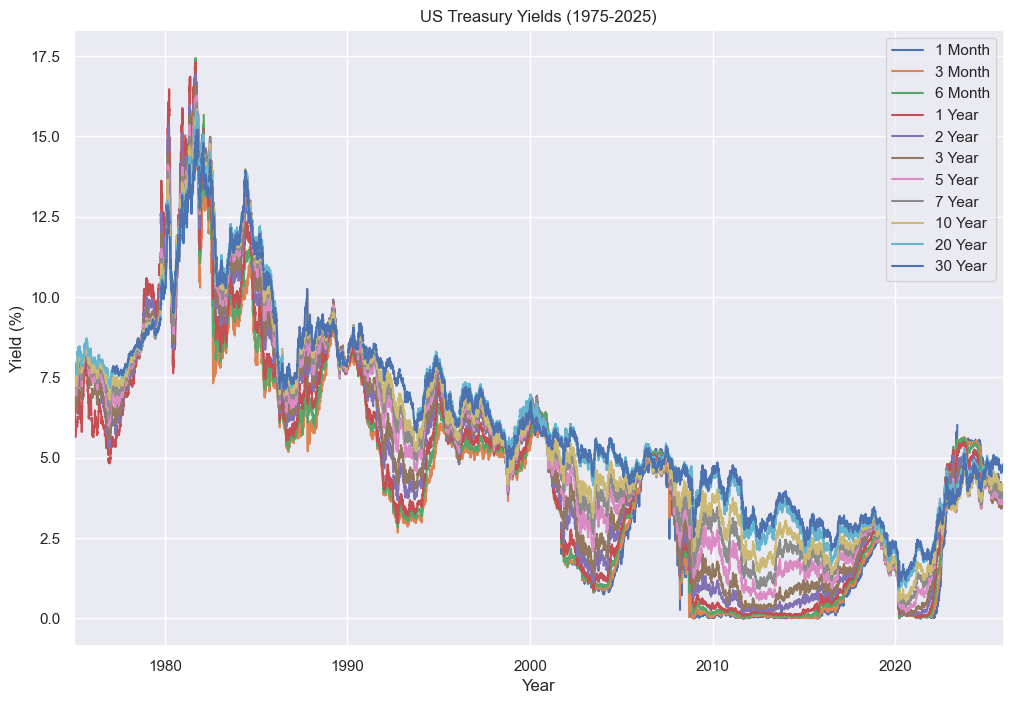

In [7]:
# 2.1 Plotting the full history of yields

plt.figure(figsize = (12, 8))
yields.plot(
    figsize = (12, 8),
    title = "US Treasury Yields (1975-2025)",
    xlabel = "Year",
    ylabel = "Yield (%)"
)
plt.show();

### 2.2 Interpreting Long-Term Yield Dynamics

From the long-term plot of U.S. Treasury yields, several broad patterns emerge:

- High and volatile yields in the late 1970s and 1980s, reflecting elevated inflation, tight monetary policy, and repeated policy shifts.
- A downward trend in yields from the mid-1980s onward, consistent with disinflation, credibility gains for central banks, and structurally lower real rates.
- A sharp decline in yields around the Global Financial Crisis (2007-2009), as investors moved into safe assets and the Fed cut policy rates aggressively.
- The zero lower bound / near-zero environment that followed, with short and medium-term rates compressed for an extended period.
- A sudden collapse in yields during the COVID-19 shock in 2020, followed by a regime of very low rates.
- A rapid repricing upward from 2021-2022, as inflation surged and the Fed tightened policy, leading to higher short-term rates and episodes of yield curve inversion.

# 3. Recession Windows and Yield Behaviour

Treasury yields tend to fall during recession periods as investors seek safety, growth expectations weaken, and monetary policy becomes more accommodative. To observe this behaviour more clearly, we zoom into specific recession episodes and examine how the 10-year yield evolved during these downturns.

### 3.1 U.S. Recessions Since 1975

Below is the list of all officially dated U.S. recessions since 1975 (NBER definitions):

- 1980 recession  
- 1981-1982 recession  
- 1990-1991 recession  
- 2001 recession (dot-com crash)  
- 2007-2009 recession (Global Financial Crisis)  
- 2020 recession (COVID-19 pandemic)

Across most of these episodes, the 10-year yield typically declines sharply as expectations for growth and inflation fall and the Federal Reserve cuts policy rates. We now visualize two major downturns relevant to our analysis: the COVID-19 shock and the Global Financial Crisis.

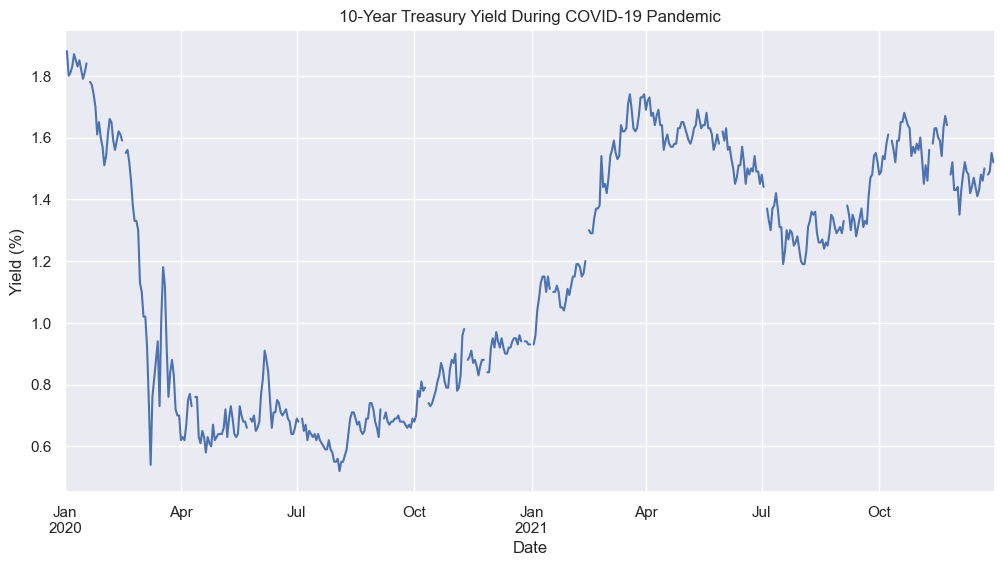

In [8]:
# 3.2 Plotting 10-Year Treasury Yield During COVID-19 (2020-2021)

yields["10 Year"]["2020-01-01":"2021-12-31"].plot(
    figsize = (12, 6),
    title = "10-Year Treasury Yield During COVID-19 Pandemic",
    xlabel = "Date",
    ylabel = "Yield (%)"
)
plt.show();

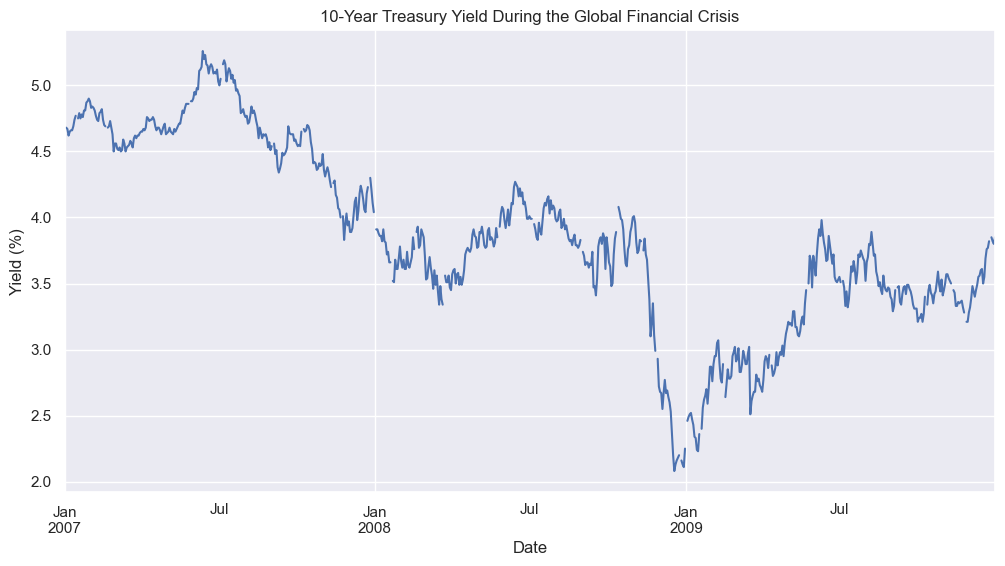

In [9]:
# 3.3 Plotting 10-Year Treasury Yield During the Global Financial Crisis (2007-2009)

yields["10 Year"]["2007-01-01":"2009-12-31"].plot(
    figsize = (12, 6),
    title = "10-Year Treasury Yield During the Global Financial Crisis",
    xlabel = "Date",
    ylabel = "Yield (%)"
)
plt.show();

## 4. Interdependence Between Treasury Yields

Different maturities of the yield curve tend to move together because they respond to common macroeconomic forces such as inflation expectations, monetary policy decisions, and risk sentiment. At the same time, each segment of the curve can react differently depending on whether economic shocks are short-lived, long-term, or driven by liquidity conditions.

To visualize these relationships, we examine the joint distribution of yields across maturities using a pairplot with kernel density estimates (KDE) on the diagonal.

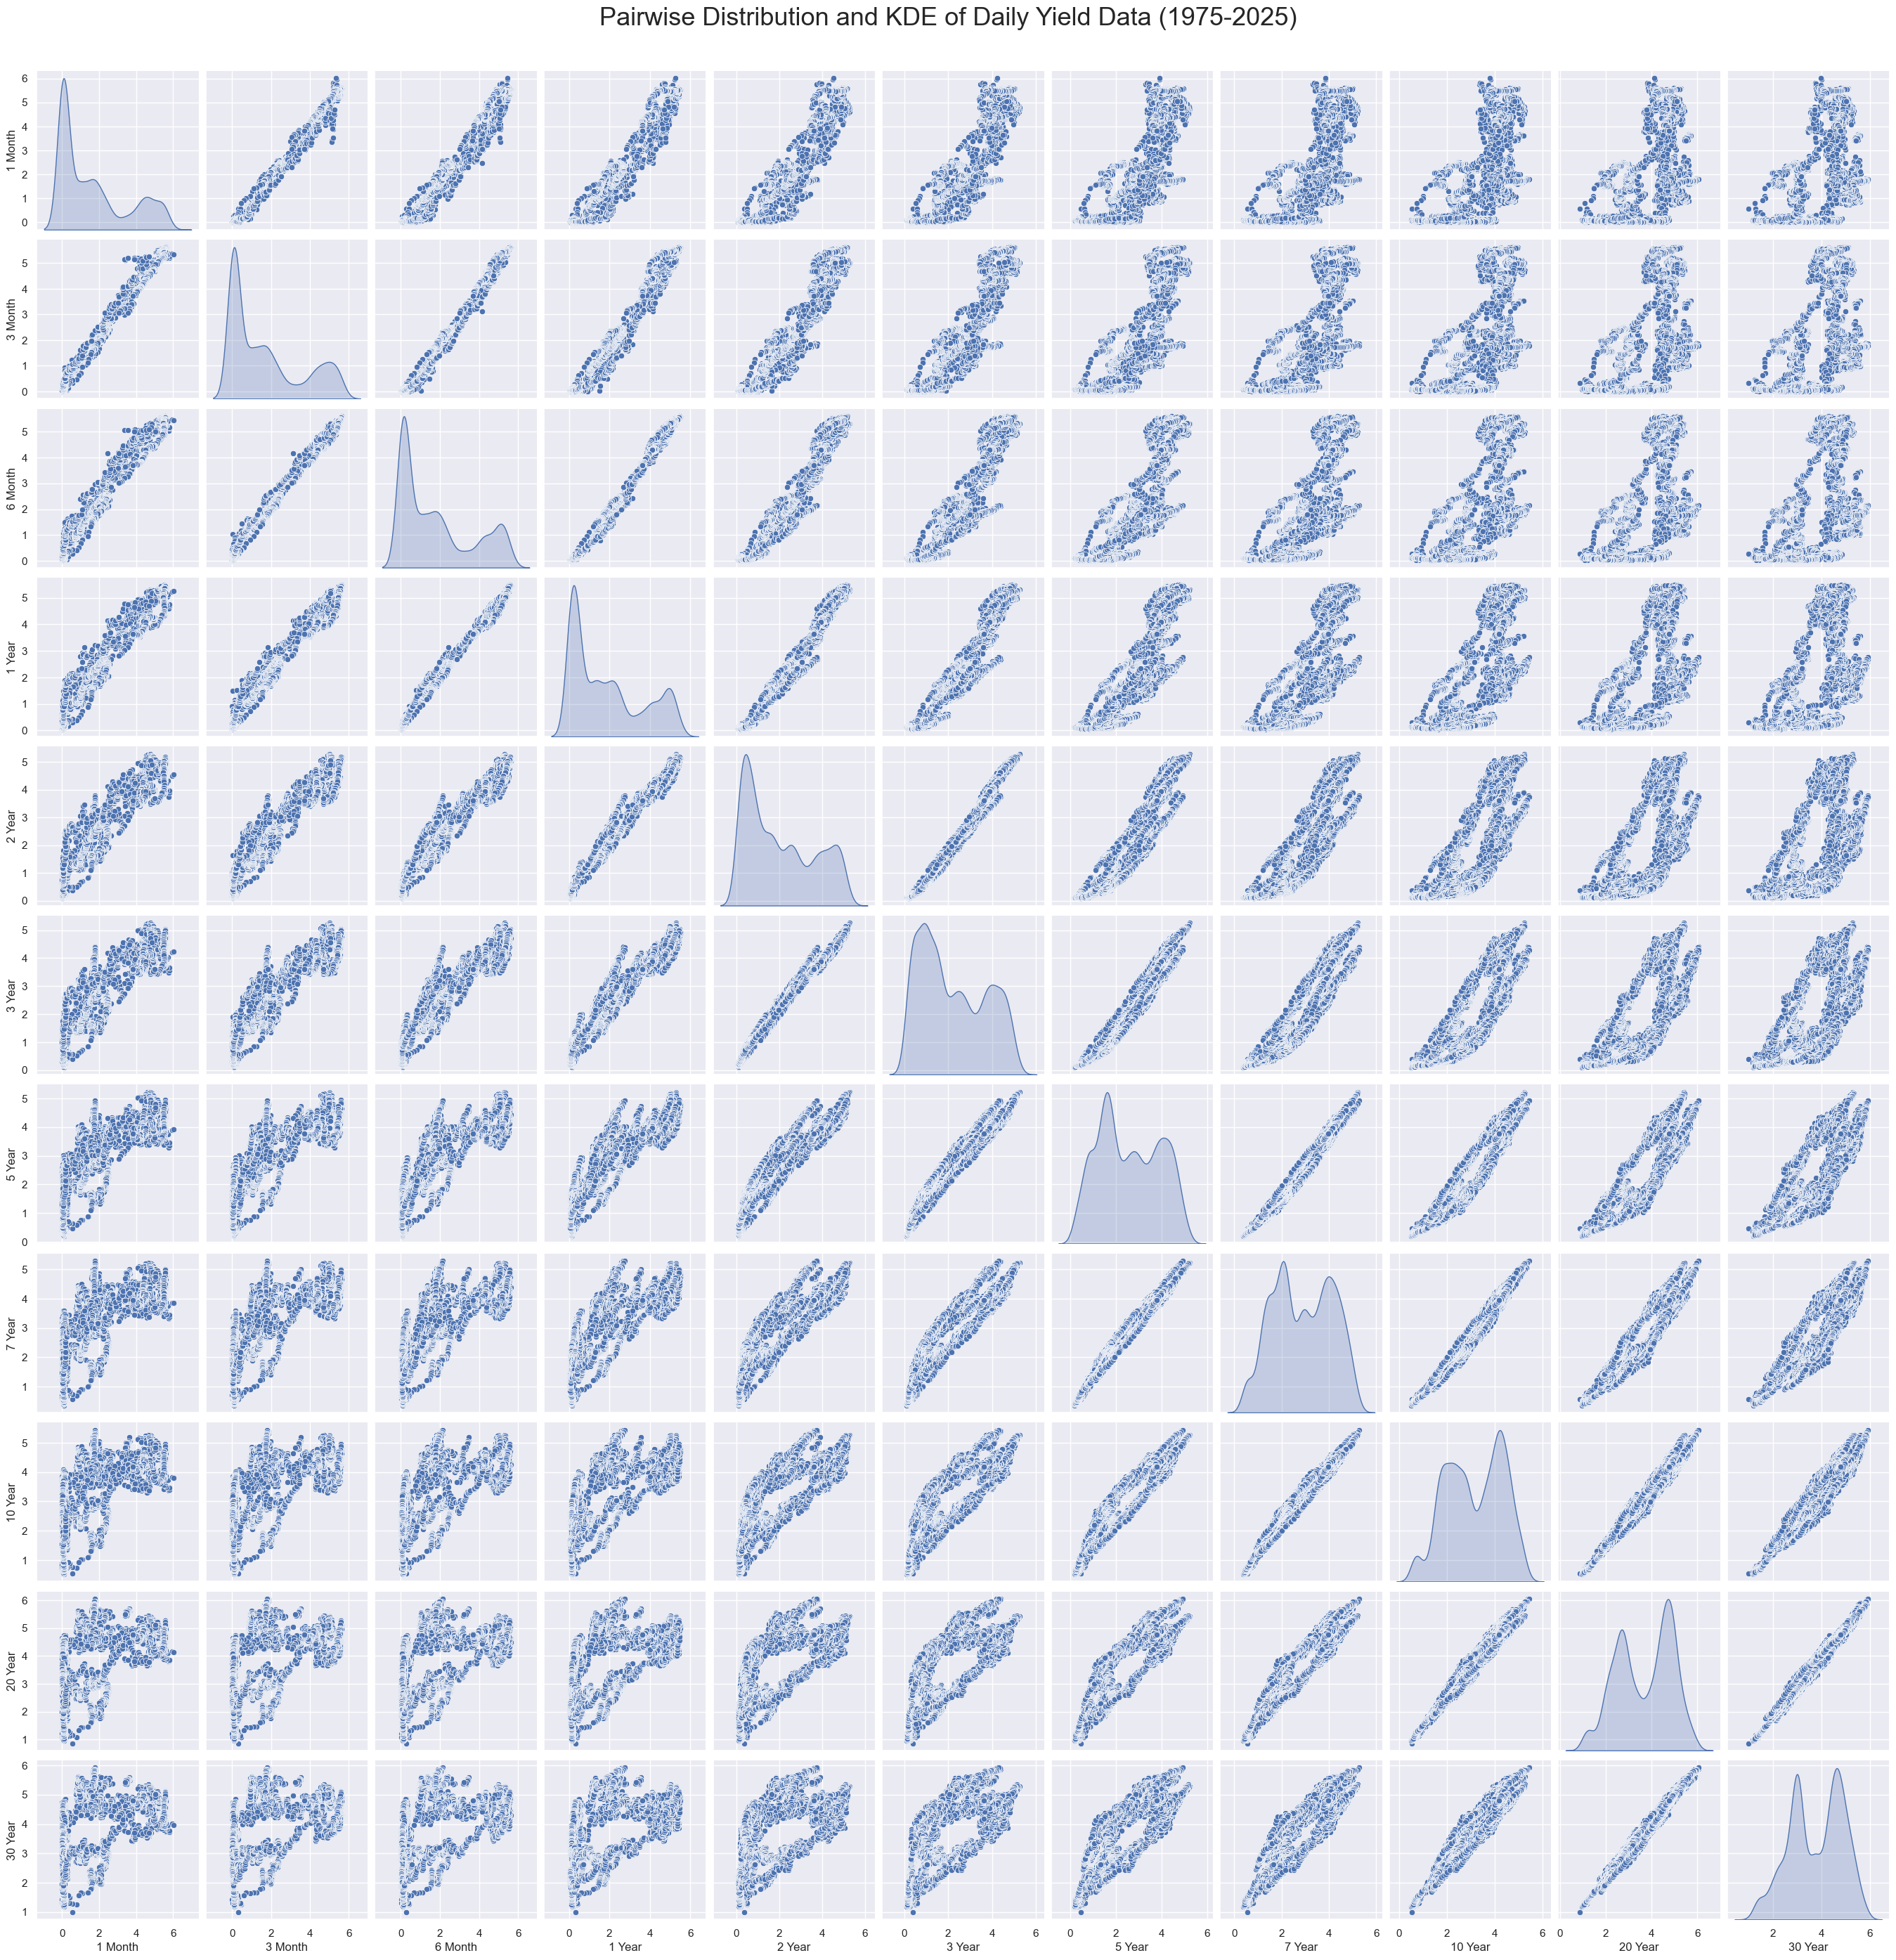

In [10]:
# 4.1 Pairwise distribution of yields

sns.pairplot(
    yields.dropna(),
    diag_kind = "kde"
)

plt.suptitle(
    "Pairwise Distribution and KDE of Daily Yield Data (1975-2025)",
    y = 1.02,
    fontsize = 26
)
plt.show();

### Interpretation

The pairplot shows two important features of the term structure:

**1. Multimodal KDE distributions**  
The diagonal KDE plots display multiple peaks, reflecting distinct macroeconomic regimes, high-inflation periods of the 1980s, the low-rate environment after the Global Financial Crisis, the zero lower bound around COVID, and the sharp repricing during the 2021-2023 tightening cycle.

**2. Strong positive correlations across maturities**  
The scatterplots indicate that short and long-term yields are strongly correlated, especially between nearby maturities. Even distant maturities (e.g., 1-month vs 30-year) retain a positive relationship, though with more dispersion.  
This behaviour is consistent with the idea that common factors; level, slope, and curvature, explain most of the variation in the yield curve.

## 5. Yield Curve Shape on Specific Dates

To see how the term structure reacts to different macroeconomic conditions, we plot the cross-section of yields (the yield curve) on selected dates. Each curve shows how short, medium, and long-term rates are aligned at a given point in time, revealing whether the curve is normal, flat, or inverted, and whether there is noticeable curvature.

In [11]:
# 5.1 Helper function to plot the yield curve on a given date

def plot_yield_curve(date_str):
    """
    Plot the US Treasury yield curve on a specific date.

    Parameters
    ----------
    date_str : str
        Date in 'YYYY-MM-DD' format that must exist in the `yields` DataFrame.
    """
    # Labels for the x-axis (maturities)
    maturities = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]
    
    # Extract the yields for the given date (in the same column order as the DataFrame)
    yc = yields.loc[date_str]

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(maturities, yc.values, marker = "D", label = f"Yield Curve at {date_str}")

    # Fixed y-axis range and ticks (adjust if needed)
    ax.set_ylim(0, 6)                       # yields from 0% to 6%
    ax.set_yticks([i * 0.5 for i in range(0, 13)])  # 0.0, 0.5, ..., 6.0
    ax.set_ylabel("Yield (%)")

    # Format x-axis and title
    ax.set_xlabel("Maturity")
    ax.set_title(f"US Treasury Yield Curve on {date_str}")

    # Optional: force nice grid and legend
    ax.grid(True, alpha = 0.3)
    ax.legend(loc = "best")

    plt.show();

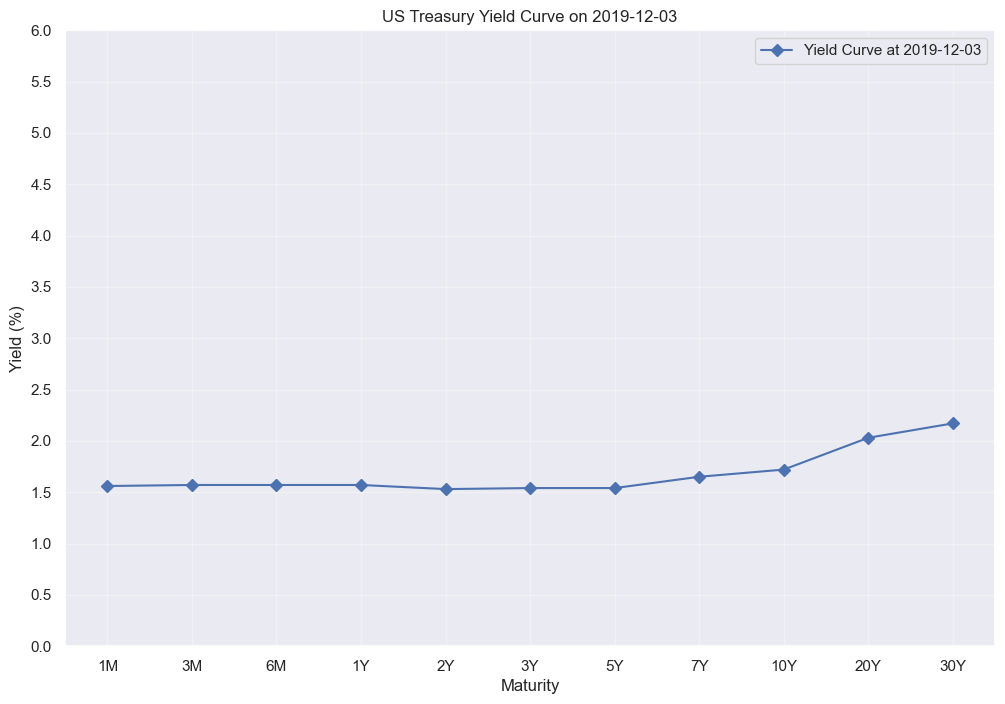

In [12]:
# 5.2 Pre-pandemic "normal" curve
plot_yield_curve("2019-12-03")

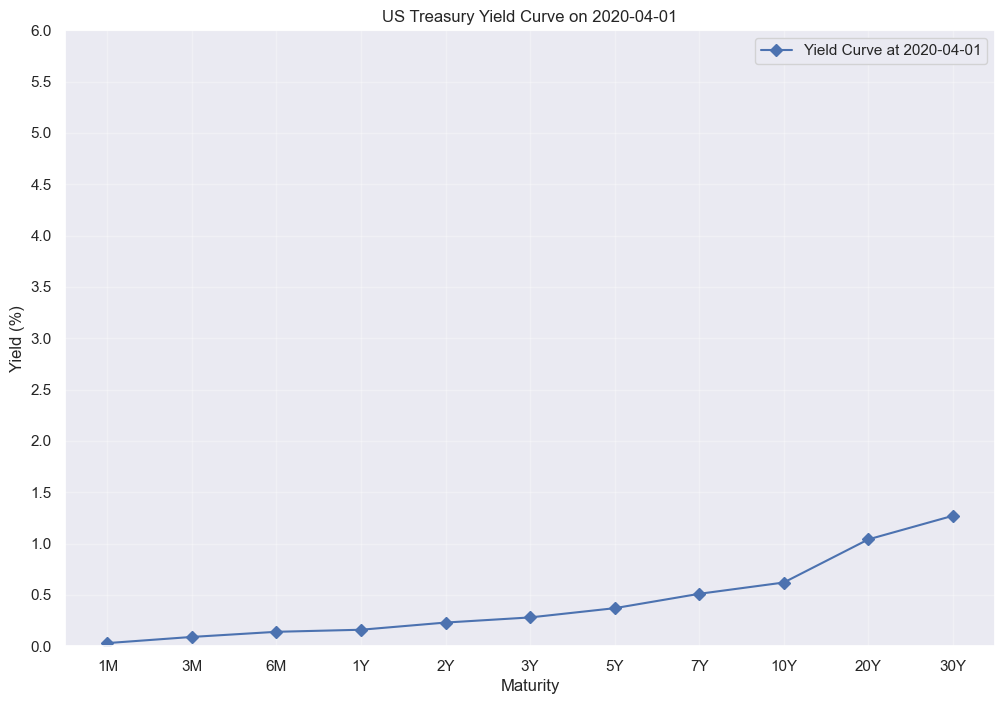

In [14]:
# 5.3 Emergency cuts and COVID shock
plot_yield_curve("2020-04-01")

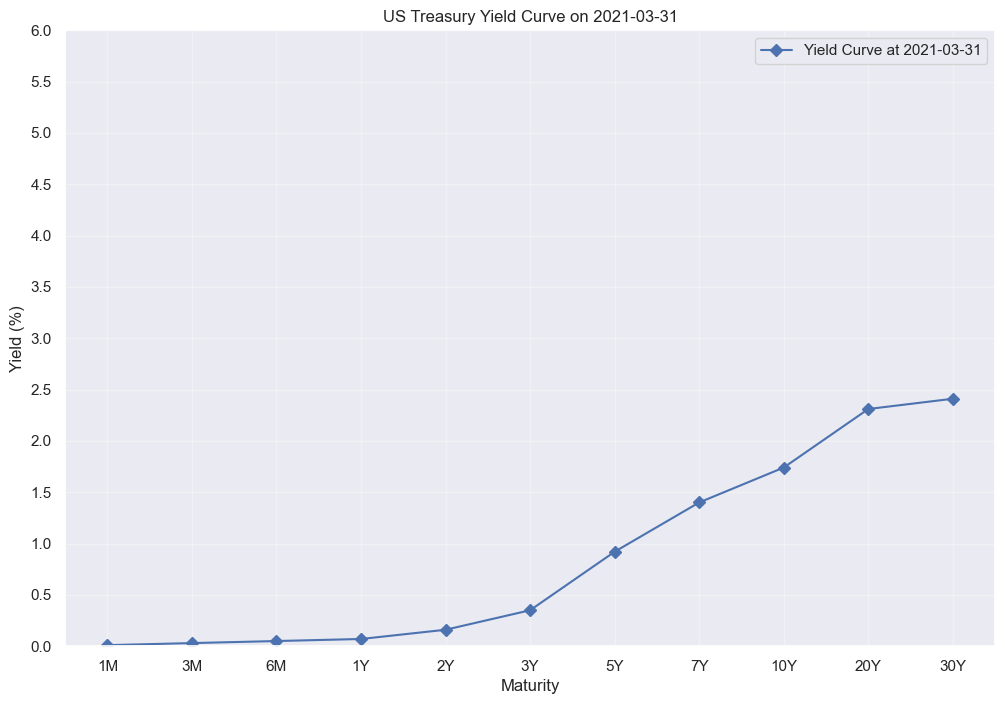

In [15]:
# 5.4 Early inflation / bear steepening phase
plot_yield_curve("2021-03-31")

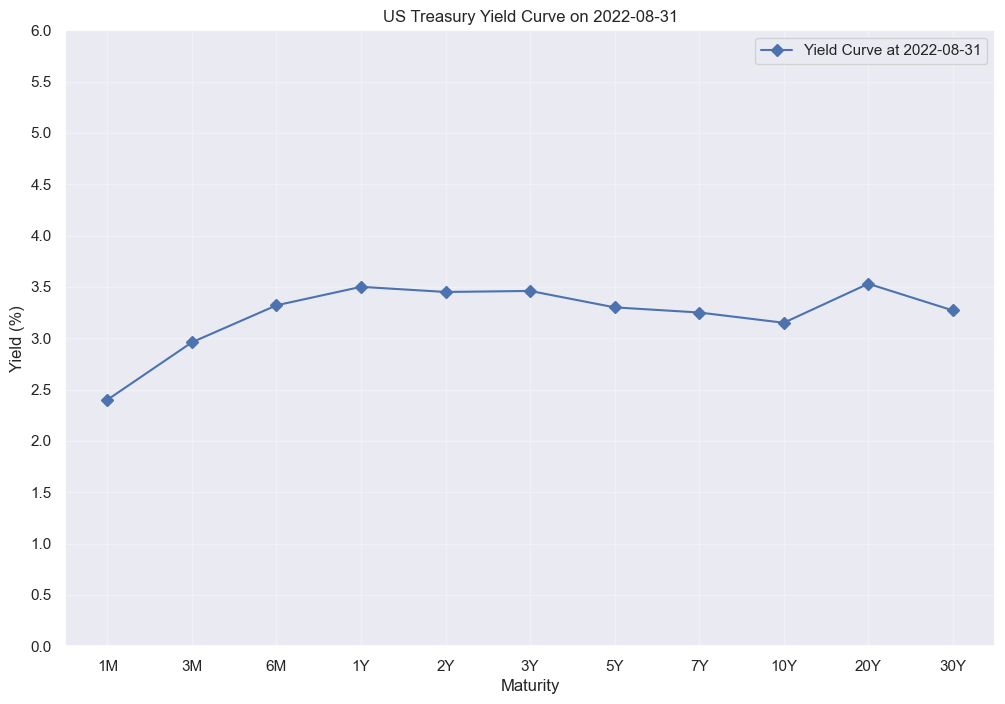

In [16]:
# 5.5 Clear inversion phase
plot_yield_curve("2022-08-31")

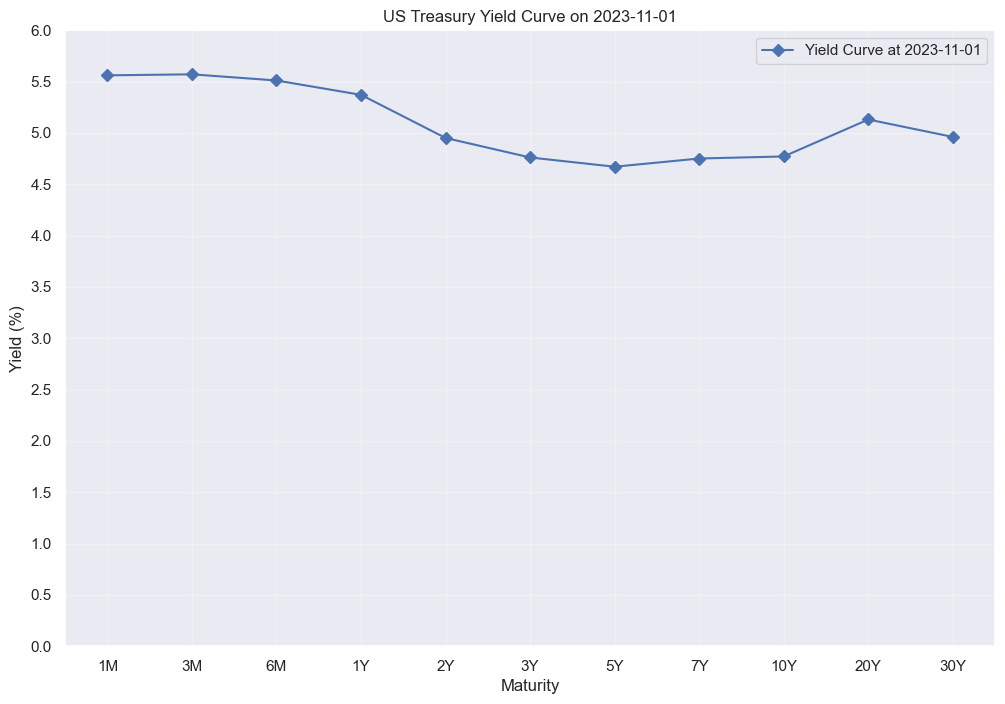

In [17]:
# 5.6 Late-cycle inversion
plot_yield_curve("2023-11-01")

## 5.7 Interpretation of Selected Yield Curves

### **2019-12-03: Pre-COVID Term Structure**
This curve reflects a late-cycle but stable environment. Short-term yields sit around 1.5-1.6%, and the long end rises gradually to approximately 2.2%. The slope is mildly positive, and the overall level is low. This pattern is typical of a mature expansion with anchored inflation expectations and steady growth.

### **2020-04-01: COVID Shock and Emergency Easing**
By April 2020, the entire curve had shifted sharply downward. Short-term yields moved close to zero following the Federal Reserve’s emergency rate cuts, while the long end also declined but remained above 1%. This is a classic bull steepening episode: yields fall most heavily at the short end, leaving the curve steeper even though the overall level is much lower.

### **2021-03-31: Reopening and Reflation Phase**
In early 2021, optimism around reopening, fiscal stimulus, and rising inflation expectations pushed long-term yields notably higher. Short-term rates stayed anchored near zero, but the 10-year and 30-year yields rose sharply. The result is a pronounced upward slope characteristic of bear steepening, where long-term rates increase faster than short-term rates.

### **2022-08-31: Belly Inversion During Tightening Cycle**
By mid-2022, aggressive rate hikes caused the short- and medium-term segment of the curve (1Y–5Y) to rise above the 10-year yield, producing a clear inversion in the belly of the curve. However, the longest maturities (20Y and 30Y) remained slightly higher than the belly. This shape reflects markets pricing in near-term recession risk while still maintaining some upward tilt in very long-term expectations.

### **2023-11-01: Deep Short-End Inversion, Late-Cycle Profile**
In late 2023, short-term yields (1M-6M) exceeded 5.5%, far above medium-term yields in the 7Y-10Y area near 4.7-4.9%. This indicates a deep inversion across short and intermediate-term maturities, consistent with a late-cycle environment featuring tight monetary policy and expectations of slower future growth. The slight rise in the 20Y-30Y segment produces a kinked shape rather than a fully downward-sloping curve.

## 6. Level, Slope, and Curvature of the Yield Curve

To summarize movements of the entire yield curve in a compact way, it is common to work with three factors:

- **Level**: the overall height of the curve (are rates generally high or low?).  
- **Slope**: the difference between long-term and short-term yields (is the curve steep, flat, or inverted?).  
- **Curvature**: how the middle of the curve behaves relative to the short and long ends (is there a hump in the belly?).

In this project, we construct simple proxies for these factors using U.S. Treasury yields:

- Level = cross-sectional average of all available maturities  
- Slope = 10-year yield - 2-year yield  
- Curvature = 2 × 5-year yield - (2-year yield + 10-year yield)

These proxies are not model-based factors but provide an intuitive view of how the term structure evolves over time, especially around the COVID shock and the subsequent tightening cycle.

In [18]:
# 6.1 Constructing level, slope, and curvature proxies

factors = pd.DataFrame(index=yields.index)

# Level: average yield across all maturities
factors["Level"] = yields.mean(axis=1)

# Slope: 10Y - 2Y
factors["Slope_10Y_2Y"] = yields["10 Year"] - yields["2 Year"]

# Curvature: 2 * 5Y - (2Y + 10Y)
factors["Curvature"] = 2 * yields["5 Year"] - (yields["2 Year"] + yields["10 Year"])

# Restrict to a recent window for clearer interpretation (e.g. 2018 onwards)
factors_recent = factors.loc["2018-01-01":]

factors_recent.tail();

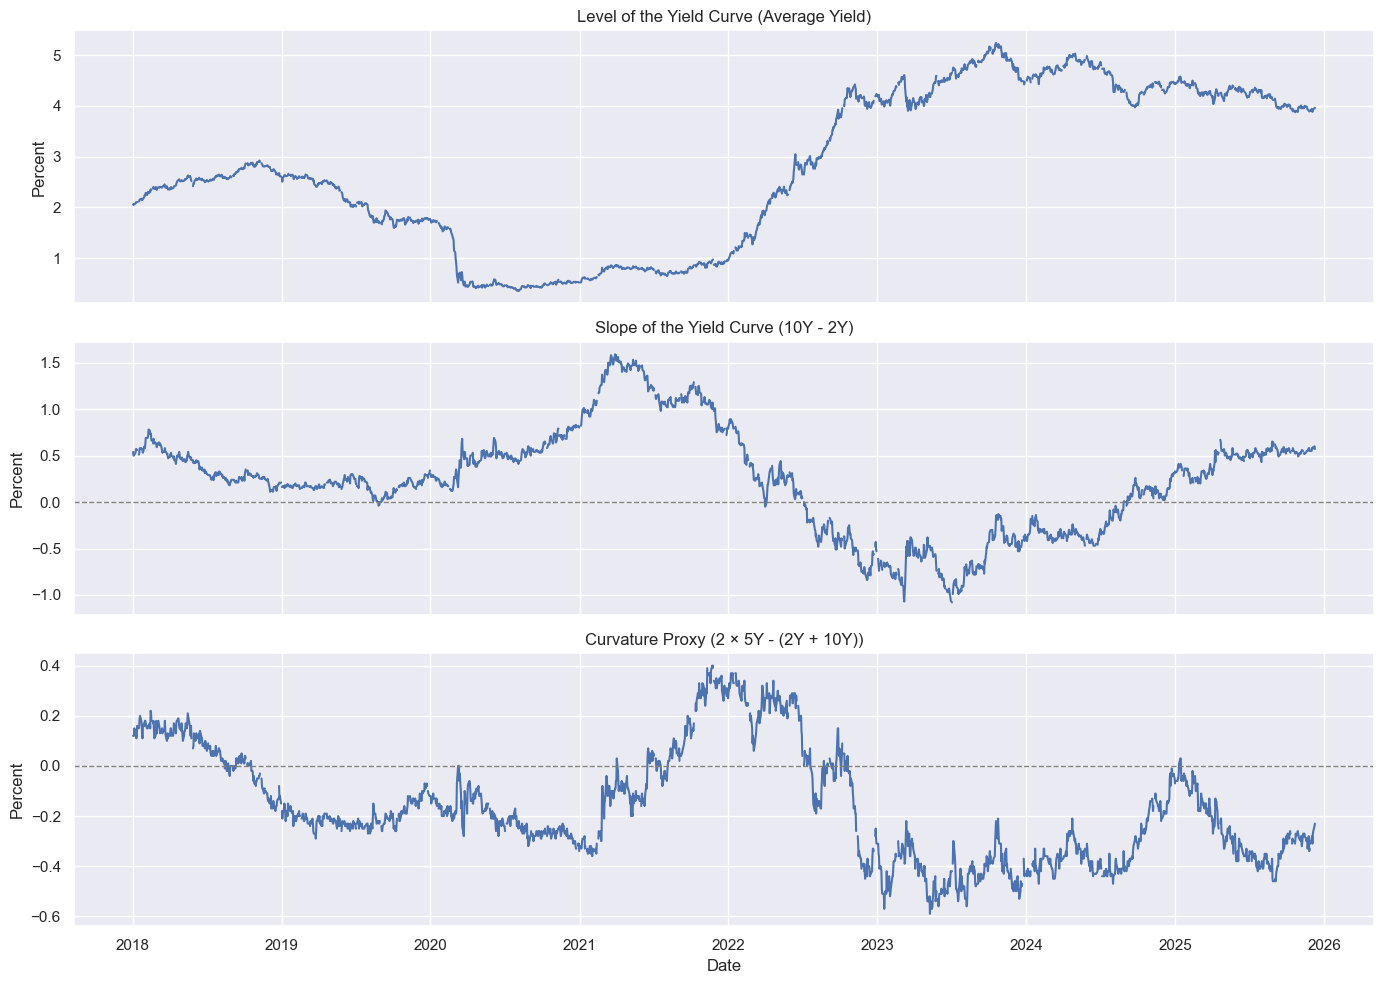

In [19]:
# 6.2 Plotting level, slope, and curvature over time (2018–present)

fig, axes = plt.subplots(3, 1, figsize = (14, 10), sharex = True)

# Level
axes[0].plot(factors_recent.index, factors_recent["Level"])
axes[0].set_title("Level of the Yield Curve (Average Yield)")
axes[0].set_ylabel("Percent")

# Slope
axes[1].plot(factors_recent.index, factors_recent["Slope_10Y_2Y"])
axes[1].axhline(0, color = "gray", linestyle = "--", linewidth = 1)
axes[1].set_title("Slope of the Yield Curve (10Y - 2Y)")
axes[1].set_ylabel("Percent")

# Curvature
axes[2].plot(factors_recent.index, factors_recent["Curvature"])
axes[2].axhline(0, color = "gray", linestyle = "--", linewidth = 1)
axes[2].set_title("Curvature Proxy (2 × 5Y - (2Y + 10Y))")
axes[2].set_ylabel("Percent")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show();

### 6.3 Interpreting the Factors (2018 - Present)

- **Level**: The average yield drops sharply in early 2020 as the COVID shock hits and policy rates are cut to the lower bound. It then climbs steadily from 2021 onwards, reflecting higher inflation and the subsequent tightening cycle.

- **Slope (10Y - 2Y)**: The slope is positive before COVID, steepens during the early reflation phase, and then moves towards zero and below as short-term rates rise faster than long-term rates. The deep negative values in 2022-2023 correspond to the pronounced yield curve inversion.

- **Curvature**: Curvature becomes more volatile around turning points in the cycle. Positive curvature indicates a hump in the belly of the curve (5Y above the average of 2Y and 10Y), while negative curvature reflects a depressed middle segment relative to the ends. During periods of strong inversion, the structure can become kinked rather than smoothly curved, which is reflected in swings of this proxy.

## 7. Level Dynamics During the COVID Shock

To examine how the overall level of the yield curve shifted during the early phase of COVID-19, we focus on the period from January to August 2020. This window captures:

- The pre-pandemic baseline  
- The March 2020 collapse in yields  
- The early stabilization phase under zero-rate policy  

We reproduce a three-panel figure showing the behaviour of yields across maturities, their monthly averages, and the month-end cross-sections of the yield curve.

In [20]:
# 7.1 Preparing the data for COVID-level dynamics (Jan–Aug 2020)

covid_period = yields.loc["2020-01-01":"2020-08-31"].iloc[:, 1:] # Exclude 1M yield due to missing values
resampled_covid_monthly = covid_period.resample("M").last()
covid_month_labels = resampled_covid_monthly.index.strftime("%Y-%m-%d")

covid_period.head()

C:\Users\Sahil\AppData\Local\Temp\ipykernel_2608\2741908674.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_covid_monthly = covid_period.resample("M").last()


3 Month  6 Month  1 Year  2 Year  3 Year  5 Year  7 Year  10 Year  \
2020-01-01      NaN      NaN     NaN     NaN     NaN     NaN     NaN      NaN   
2020-01-02     1.54     1.57    1.56    1.58    1.59    1.67    1.79     1.88   
2020-01-03     1.52     1.55    1.55    1.53    1.54    1.59    1.71     1.80   
2020-01-06     1.56     1.56    1.54    1.54    1.56    1.61    1.72     1.81   
2020-01-07     1.54     1.56    1.53    1.54    1.55    1.62    1.74     1.83   

            20 Year  30 Year  
2020-01-01      NaN      NaN  
2020-01-02     2.19     2.33  
2020-01-03     2.11     2.26  
2020-01-06     2.13     2.28  
2020-01-07     2.16     2.31

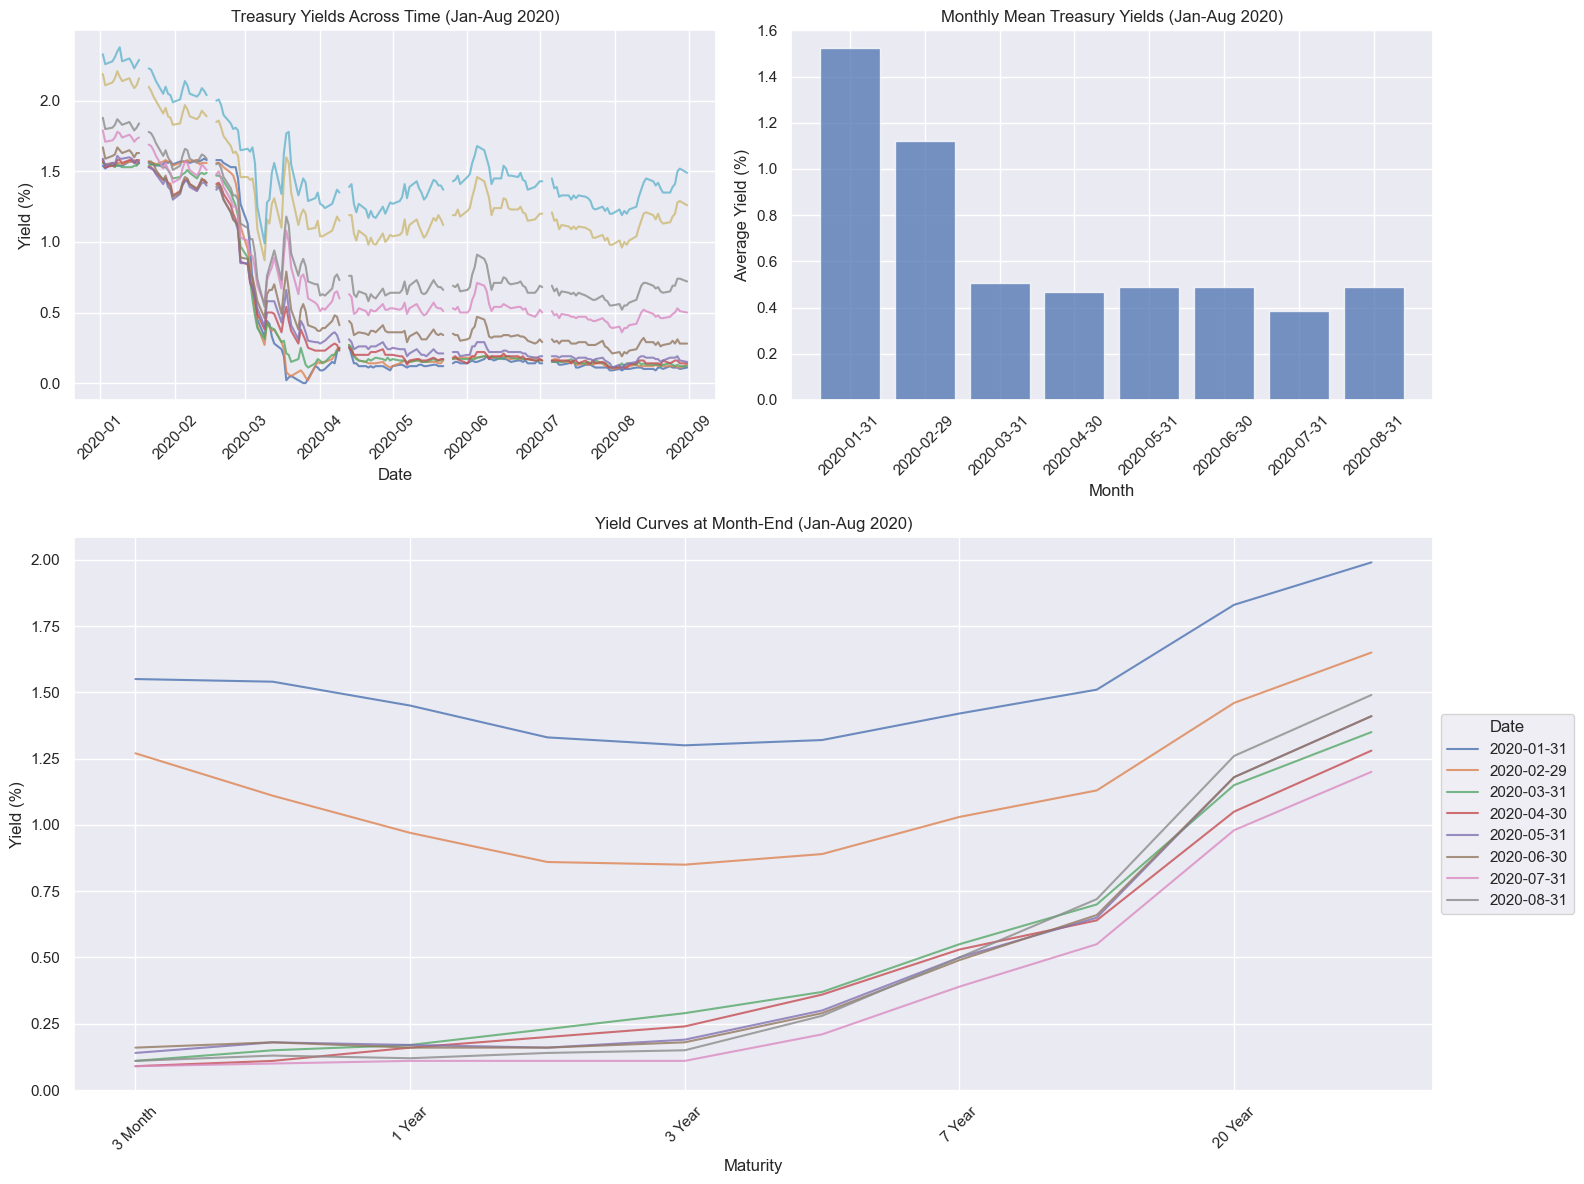

In [23]:
from matplotlib.gridspec import GridSpec

# 7.2 Reproducing the 3-panel level dynamics figure

fig = plt.figure(figsize = (16, 12))
gs = GridSpec(2, 2, height_ratios = [1, 1.5])

# Graph 1: Yields across time
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(covid_period, alpha = 0.8)
ax1.set_title("Treasury Yields Across Time (Jan-Aug 2020)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Yield (%)")
ax1.tick_params(axis="x", rotation=45)

# Graph 2: Monthly mean yields
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(
    covid_month_labels,
    resampled_covid_monthly.mean(axis=1),
    alpha = 0.75
)
ax2.set_title("Monthly Mean Treasury Yields (Jan-Aug 2020)")
ax2.set_xlabel("Month")
ax2.set_ylabel("Average Yield (%)")
ax2.tick_params(axis = "x", rotation = 45)

# Graph 3: Yield curves at each month-end
ax3 = fig.add_subplot(gs[1, :])
for i in range(len(resampled_covid_monthly)):
    date = covid_month_labels[i]
    resampled_covid_monthly.iloc[i, :].plot(
        ax = ax3, alpha = 0.8, label = date
    )

ax3.set_title("Yield Curves at Month-End (Jan-Aug 2020)")
ax3.set_xlabel("Maturity")
ax3.set_ylabel("Yield (%)")
ax3.legend(title = "Date", loc = "center left", bbox_to_anchor = (1, 0.5))
ax3.tick_params(axis = "x", rotation = 45)

plt.tight_layout()
plt.show();

### Interpretation

The early COVID period shows a dramatic collapse in the **level** of the yield curve:

- **Graph 1** shows an abrupt decline across all maturities in March 2020 as the pandemic triggered a global flight to safety and emergency Fed rate cuts.
- **Graph 2** highlights how monthly average yields dropped sharply between January and April, stabilizing near historical lows by mid-2020.
- **Graph 3** shows month-end yield curves shifting downward almost in parallel, with the short end pinned near zero while the long end remained above 1%.  

This is a clean example of a large **parallel downward shift**, the hallmark of a level shock.

## 8. Slope Dynamics of the Yield Curve

The slope of the yield curve captures how long-term rates compare to short-term rates and is one of the most informative dimensions of term-structure dynamics. During the COVID era and its aftermath, the U.S. Treasury market experienced two distinct slope regimes:

1. **Bear Steepening (2021)**: driven by reopening, fiscal stimulus, and rising inflation expectations.  
2. **Bear Flattening and Inversion (2022)**: driven by aggressive Federal Reserve tightening.

We reproduce a two-panel figure to visualize these slope dynamics.

In [24]:
# 8.1 Preparing data windows for slope dynamics

# Bear Steepening (2021)
bear_steepening = yields["2021-01-01":"2021-12-31"].resample("3M").last()
bear_steepening.index = bear_steepening.index.strftime("%Y-%m-%d")

# Bear Flattening + Inversion (2022)
bear_flattening_inversion = yields["2022-01-01":"2022-12-31"].resample("3M").last()
bear_flattening_inversion.index = bear_flattening_inversion.index.strftime("%Y-%m-%d")

C:\Users\Sahil\AppData\Local\Temp\ipykernel_2608\2167034931.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bear_steepening = yields["2021-01-01":"2021-12-31"].resample("3M").last()
C:\Users\Sahil\AppData\Local\Temp\ipykernel_2608\2167034931.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bear_flattening_inversion = yields["2022-01-01":"2022-12-31"].resample("3M").last()


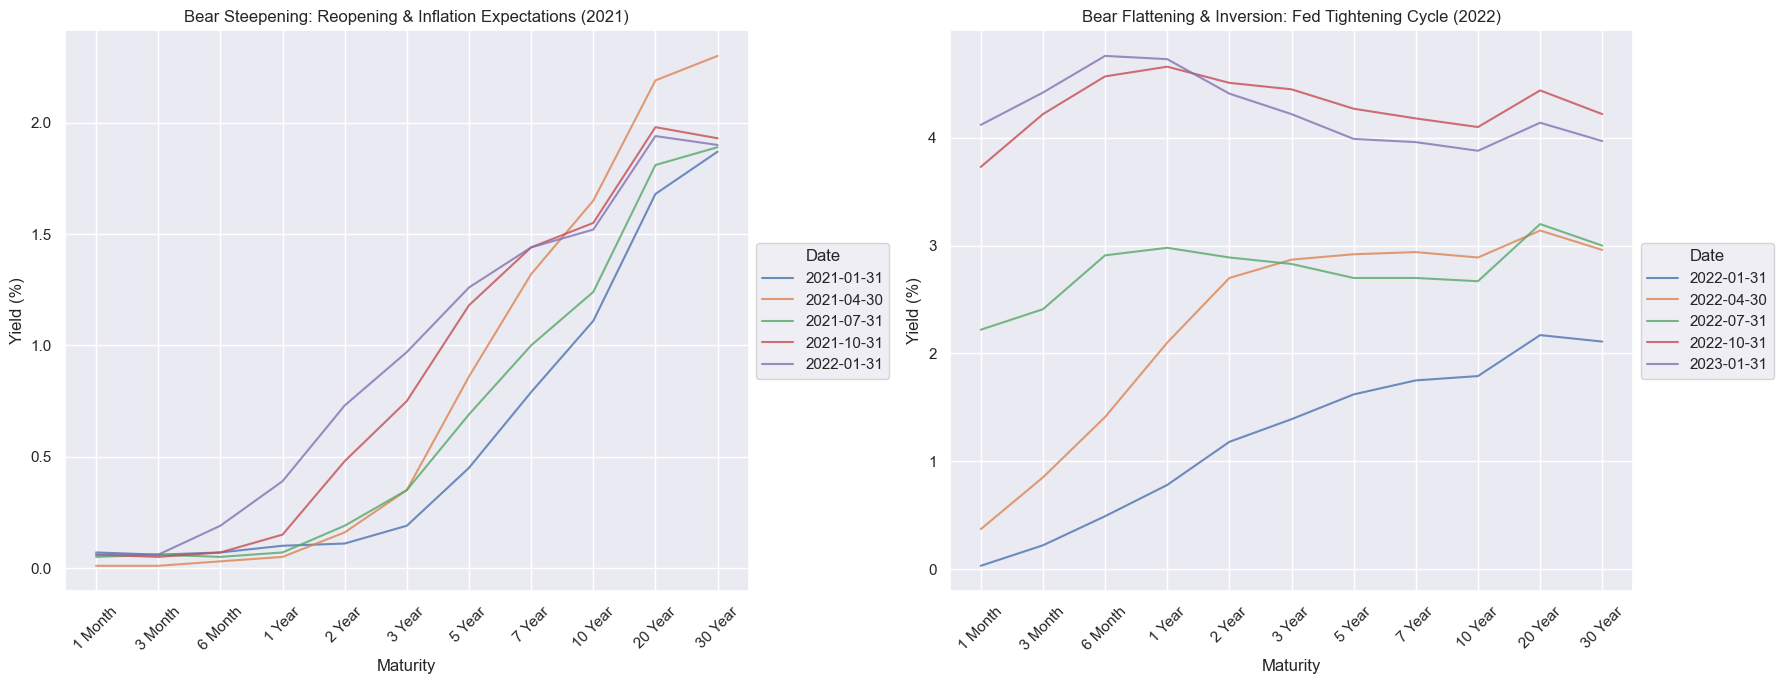

In [25]:
# 8.2 Creating the two-panel slope dynamics figure

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Panel 1: Bear Steepening (2021) ---
for i in range(len(bear_steepening)):
    date = bear_steepening.index[i]
    ax1.plot(
        bear_steepening.columns,
        bear_steepening.iloc[i, :],
        alpha=0.8,
        label=date
    )

ax1.set_title("Bear Steepening: Reopening & Inflation Expectations (2021)")
ax1.set_xlabel("Maturity")
ax1.set_ylabel("Yield (%)")
ax1.tick_params(axis="x", rotation=45)
ax1.legend(title="Date", loc="center left", bbox_to_anchor=(1, 0.5))

# --- Panel 2: Bear Flattening / Inversion (2022) ---
for i in range(len(bear_flattening_inversion)):
    date = bear_flattening_inversion.index[i]
    ax2.plot(
        bear_flattening_inversion.columns,
        bear_flattening_inversion.iloc[i, :],
        alpha=0.8,
        label=date
    )

ax2.set_title("Bear Flattening & Inversion: Fed Tightening Cycle (2022)")
ax2.set_xlabel("Maturity")
ax2.set_ylabel("Yield (%)")
ax2.tick_params(axis="x", rotation=45)
ax2.legend(title="Date", loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show();


### Interpretation of Slope Dynamics

#### **2021 - Bear Steepening**
During 2021, the long end of the yield curve rose significantly faster than the short end. This reflected stronger economic growth expectations, reopening momentum, and rising inflation forecasts. With policy rates still pinned near zero, upward pressure was concentrated in longer maturities, producing a classic **bear steepening** pattern.

#### **2022 - Bear Flattening and Inversion**
In 2022, the Federal Reserve began an aggressive tightening cycle. Short-term yields rose extremely quickly in response to repeated rate hikes, while long-term yields rose much more slowly due to expectations of slower future growth and eventual disinflation. This produced a **bear flattening** pattern that eventually led to a clear **inversion** of the short and intermediate-term segments of the curve.

## 9. 10Y-2Y Spread vs S&P 500

The 10-year minus 2-year Treasury spread is one of the most widely monitored recession indicators. When the spread turns negative (yield curve inversion), it often signals future economic slowdowns.  

Here, we compare the 10Y-2Y spread with the performance of the S&P 500 to examine how equity markets evolve around periods of curve flattening and inversion.

In [ ]:
# 9.1 Downloading S&P 500 index from FRED

sp500 = fred.get_series(
    "SP500",
    observation_start = "1975-01-01",
    observation_end = "2025-12-10"
)

sp500 = pd.DataFrame(sp500, columns = ["SP500"])
sp500.index = pd.to_datetime(sp500.index)

sp500.tail()

SP500
2025-12-04  6857.12
2025-12-05  6870.40
2025-12-08  6846.51
2025-12-09  6840.51
2025-12-10  6886.68

In [ ]:
# 9.2 Combining S&P500 with the factors DataFrame

exercise_df = factors.copy()
exercise_df = exercise_df.join(sp500, how = "inner")

exercise_df.tail()

Level  Slope_10Y_2Y  Curvature    SP500
2025-12-03  3.881818          0.57      -0.31  6849.72
2025-12-04  3.912727          0.59      -0.27  6857.12
2025-12-05  3.933636          0.58      -0.26  6870.40
2025-12-08  3.950909          0.60      -0.24  6846.51
2025-12-09  3.962727          0.57      -0.23  6840.51

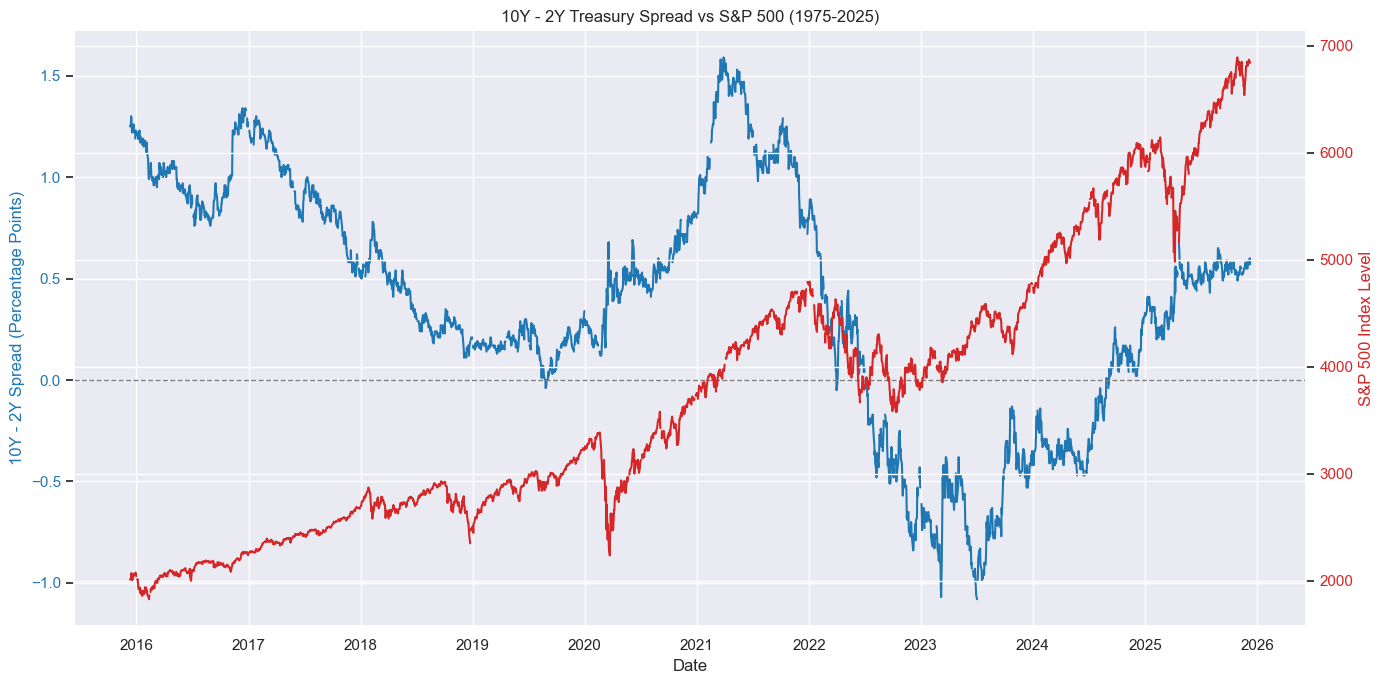

In [30]:
# 9.3 Creating the double-axis plot for the 10Y–2Y spread vs S&P 500

fig, ax1 = plt.subplots(figsize = (14, 7))

# Left axis → 10Y–2Y Spread
ax1.plot(
    exercise_df.index,
    exercise_df["Slope_10Y_2Y"],
    color = "tab:blue",
    label = "10Y - 2Y Spread"
)
ax1.set_xlabel("Date")
ax1.set_ylabel("10Y - 2Y Spread (Percentage Points)", color = "tab:blue")
ax1.tick_params(axis = "y", labelcolor = "tab:blue")
ax1.axhline(0, color = "gray", linestyle = "--", linewidth = 1)

# Right axis → S&P 500
ax2 = ax1.twinx()
ax2.plot(
    exercise_df.index,
    exercise_df["SP500"],
    color = "tab:red",
    label = "S&P 500"
)
ax2.set_ylabel("S&P 500 Index Level", color = "tab:red")
ax2.tick_params(axis = "y", labelcolor = "tab:red")

plt.title("10Y - 2Y Treasury Spread vs S&P 500 (1975-2025)")
fig.tight_layout()
plt.show();

### Interpretation of the 10Y-2Y Spread vs S&P 500

- Periods where the **10Y-2Y spread declines sharply** or turns negative typically occur during the late phase of economic expansions.  
- Yield curve **inversions** (spread < 0) often precede recessions by 6-18 months, marking heightened concern about future growth.
- During inversions such as:
  - **2000**,  
  - **2006**,  
  - **2019-2020**,  
  - **2022-2023**,  
  the S&P 500 often shows increased volatility or begins trending sideways/down before the economic downturn is fully realized.

- Equity markets do not always collapse immediately when the curve inverts, but the inversion highlights underlying macro pressures: tighter monetary policy, decelerating growth expectations, and rising recession risk.

## 10. Conclusion

This project examined the behaviour of the U.S. Treasury yield curve from 1975 through 2025, with a particular focus on the COVID-19 shock and the tightening cycle that followed. By combining long-horizon data from FRED with targeted visualisations, we explored how yields moved across different maturities and how shifts in level, slope, and curvature captured changes in macroeconomic conditions.

The long-term evolution of yields showed distinct historical regimes: the high-inflation environment of the 1980s, the post-GFC period of persistently low rates, the dramatic downward shift during COVID, and the sharp repricing in 2021–2023 as inflation accelerated and monetary policy tightened.

Zooming into recession windows reinforced the countercyclical behaviour of yields. During both the Global Financial Crisis and the COVID shock, the 10-year yield fell rapidly as investors sought safety and growth expectations weakened. The COVID episode was especially abrupt, with nearly the entire curve dropping in parallel as policy rates approached the lower bound.

Pairwise yield relationships highlighted the strong comovement across maturities and the presence of multiple interest-rate regimes. Yield curve snapshots on selected dates illustrated how the curve transitioned from a normal shape prior to COVID, to a compressed and near-flat structure during the crisis, to a steepening pattern during the reopening phase, and finally to a deep inversion during the tightening cycle.

Using level, slope, and curvature proxies provided a compact way to track these shifts. The level factor showed the collapse in early 2020 and the subsequent rise as inflation took hold. The slope factor captured the move from early reflation to the most pronounced inversion in more than two decades. Curvature became more volatile around turning points, reflecting kinks in the term structure as different maturities responded unevenly to policy changes.

Finally, comparing the 10-year minus 2-year spread with the S&P 500 underscored the role of the yield curve as an early warning indicator. Equity markets tend not to react instantly to curve inversions, but the slope reliably signals late-cycle conditions and rising recession risk.